In [1]:
# Imports
import math
import torch
import torchvision
import torch.nn as nn  
import torch.nn.functional as F  
import torchvision.datasets as datasets  
import torchvision.transforms as transforms  
from torch.utils.data import DataLoader
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
experiment = "CIFAR10"
# Load Data
train_set = torchvision.datasets.CIFAR10(root="./CIFAR10", train = True, download = True, transform = data_transforms["train"])
test_set = torchvision.datasets.CIFAR10(root="./CIFAR10", train = False, download = True, transform = data_transforms["test"])
train_size = len(train_set)
test_size = len(test_set)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
batch_size = 16
num_workers = 1
classes = train_set.classes
num_class = len(classes)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
num_batches = math.floor(train_size/batch_size)
print(f"Number of classes: {num_class}")
print(f"Number of batches: {num_batches}")

Number of classes: 10
Number of batches: 3125


In [6]:
# Model
model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_widese_b0', pretrained=True)
in_fc = model.classifier.fc.in_features
model.classifier.fc = nn.Linear(in_fc, num_class)

Using cache found in /Users/Trieu/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/Users/Trieu/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/Users/Trieu/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


In [7]:
num_epochs = 1
learning_rate = 0.01

torch.cuda.empty_cache()

# Initialize network
model.to(device)
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
writer = SummaryWriter(f"runs/{experiment}/BatchSize {batch_size} LR {learning_rate}")

# Inspect the model
images, _ = next(iter(train_loader))
writer.add_graph(model, images.to(device))
writer.close()

# Progress bar
outer = tqdm(total=num_epochs, unit="epochs", position=0, desc="Epoch")
inner = tqdm(total=num_batches, unit="batches", position=1, desc="Batch")
batch_log = tqdm(total=0, position=3, bar_format='{desc}')

# Train
epoch_dict = {}
step = 0
for epoch in range(num_epochs):
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)                          # N, C, W, H
        labels = labels.to(device)                          # N

        # forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, predictions = outputs.max(1)                     # N
        step_accuracy = (predictions == labels).sum() / inputs.shape[0]
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        step += 1
        
        # update dict at end epoch
        if batch_idx == num_batches - 1:
            epoch_dict[epoch] = {"loss": round(loss.item(), 4),
                                 "accuracy": round(step_accuracy.item(), 4)}
            
        # TensorBoard
        writer.add_histogram("Classifier layer parameter", model.classifier.fc.weight)
        writer.add_scalar("Training loss", loss, global_step=step)
        writer.add_scalar("Training Accuracy", step_accuracy, global_step=step)
        
        # update progression bar
        batch_log.set_description_str(f"loss: {round(loss.item(), 4)}, accuracy: {step_accuracy}")
        inner.update(1)
    outer.update(1)

print("Training completed.")

Epoch:   0%|          | 0/1 [00:00<?, ?epochs/s]

Batch:   0%|          | 0/3125 [00:00<?, ?batches/s]

Training completed.


In [8]:
for i in epoch_dict:
    print(f"Epoch {i + 1} - Loss:", epoch_dict[i]["loss"], "accuracy:", epoch_dict[i]["accuracy"])

Epoch 1 - Loss: 0.5257 accuracy: 0.8125


In [9]:
# Save model
params_path = "./model/model_params"
torch.save(model.state_dict(), params_path)

In [10]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


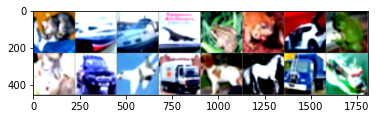

GroundTruth:  cat   ship  ship  airplane


In [11]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.to(device)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [12]:
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  airplane


In [13]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 88 %


In [14]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: airplane is 83.8 %
Accuracy for class: automobile is 95.0 %
Accuracy for class: bird  is 86.5 %
Accuracy for class: cat   is 74.5 %
Accuracy for class: deer  is 91.0 %
Accuracy for class: dog   is 87.9 %
Accuracy for class: frog  is 91.3 %
Accuracy for class: horse is 85.0 %
Accuracy for class: ship  is 93.8 %
Accuracy for class: truck is 89.3 %


In [ ]:
# Load model for validation
params_path = "./model/model_params"
# Model
model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_widese_b0', pretrained=True)
in_fc = model.classifier.fc.in_features
model.classifier.fc = nn.Linear(in_fc, num_class)
model.load_state_dict(torch.load(params_path))
model.eval()

In [ ]:
from tqdm.notebook import tqdm